# WCS Header Impact on ASTAP Color Extraction

When performing color extraction using ASTAP, ASTAP produces an image that has a WCS that throws off VPHOT by a few minutes.  Other applications (AstroImageJ, MaximDL, sextractor) also appear to have problems with the produced files. 

In the course of researching what might be the cause I tried to reproduce the issue suing Astropy WCS function all_pix2world, which reads the FITS WCS header values and produces a ra/dec map for each pixel.  I was expecting that if there were a problem with ASTAP that this would reproduce in Astropy WCS, but it does not appear to.  Additionally importing the color extracted file in another application Siril, also appears to work fine.

Provided the approach below is sound, and the code is correct, I'm offering this to help better understand the problem.

## Approach:

I generated a calibrated image of W UMa and a color extracted image (Tri-color green or TG) using ASTAP.

#### For both images I did the following:

1) Identified the pixel location of W UMa in the image using matplotlib (so that this is independent of ASTAP)
2) Identify the ra and dec of that pixel using the Astropy [wcs.all_pix2world](https://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS.all_pix2world), which uses the WCS headers to identify the ra and dec of the pixel.
3) Compared these values to the expected ra and dec of W UMa (obtained through AAVSO data set in Vizier)

#### Expectation was that: 
1) Calibrated image would match in RA and DEC, since this appears to not have problems in other applications
2) TG image would not match in RA and DEC, given the challenges VPHOT and the other apps had.

#### Findings are:
That both Cal and TG images had correct mappings for RA and DEC.

#### Additional test:
I imported the calibrated and TG images into another application called Siril.  Here I had expected that the calibrated image would match RA and DEC when hovering over W UMa, which it did.  However I noticed that the TG image also matched the RA and DEC when hovering over W UMa, unlike the findings in VPHOT and other apps.


# Setup

## Imports

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt

## Notebook Functions

In [2]:
# This function assigns RA, DEC to each pixel based upon WCS FITS header.
def get_radec_at_pixel(fits_file, x, y):
    with fits.open(fits_file) as hdul:
        header = hdul[0].header
    
    wcs = WCS(header)
    
    ra_deg, dec_deg = wcs.all_pix2world(x, y, 0)  
    
    ra_angle = Angle(ra_deg, unit=u.degree)
    dec_angle = Angle(dec_deg, unit=u.degree)
    
    return ra_angle, dec_angle

# Displays the fits file and draws a circle to highlight the a selected pixel
def highlight_star(fits_path, title, star_x, star_y):
    hdu_list = fits.open(fits_path)
    image_data = hdu_list[0].data
    hdu_list.close()

    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower',
               vmin=np.percentile(image_data, 5), vmax=np.percentile(image_data, 95))

    # Highlight the star with subtle grid lines
    plt.axvline(x=star_x, color='red', linestyle='--', linewidth=0.5)
    plt.axhline(y=star_y, color='red', linestyle='--', linewidth=0.5)

    # Annotating the axes with the coordinates
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)  # Prevent offset formatting on axes
    plt.text(star_x, plt.gca().get_ylim()[0] + 5, f'{star_x}', color='white', verticalalignment='bottom')
    plt.text(plt.gca().get_xlim()[0] + 5, star_y, f'{star_y}', color='white', horizontalalignment='left')

    plt.title(title)
    plt.show()


# This function returns RA and DEC of a AAVSO variable
def query_variable_star(star_name):
    v = Vizier(columns=['*'])
    v.ROW_LIMIT = 5  # Limit the number of rows to keep the output manageable

    # Query the VSX (Variable Star Index) catalog
    result = v.query_object(star_name, catalog=["B/vsx/vsx"])

    # Check if results were returned
    if result and len(result) > 0:
        vsx_table = result[0]  # Assuming the star is found in the first returned table        
        ra_angle = Angle(vsx_table['RAJ2000'][0]/15.0, u.hour)
        dec_angle = Angle(vsx_table['DEJ2000'][0], u.deg)       
        
        return ra_angle, dec_angle

    else:
        print("No results found for", star_name)
        return {}

## Set up FITS files and get RA/Dec from W UMa

In [3]:
# Calibrated File - Done with ASTAP
cal_fit = 'Light_WUMa_10.0s_Bin1_20240416-204402_0001_cal.fit'

# Tri color green extracted file - Done with ASTAP
tg_fit = 'Light_WUMa_10.0s_Bin1_20240416-204402_0001_cal_TG.fit'

# Get data on W UMa
ra, dec = query_variable_star('W Uma')
print(f"W UMa ra:{ra.to_string(unit=u.hourangle, sep=':', pad=True)}, dec:{dec.to_string(unit=u.degree, sep=':', pad=True)}")

W UMa ra:09:43:45.4704, dec:55:57:09.108


# Analysis

In [4]:
# Note: Uncomment this line to switch matplotlib to "interactive mode"  
# This allows verification of the chosen pixel values for each image.

#%matplotlib notebook  

## Compare ASTAP (calibrated) for accuracy

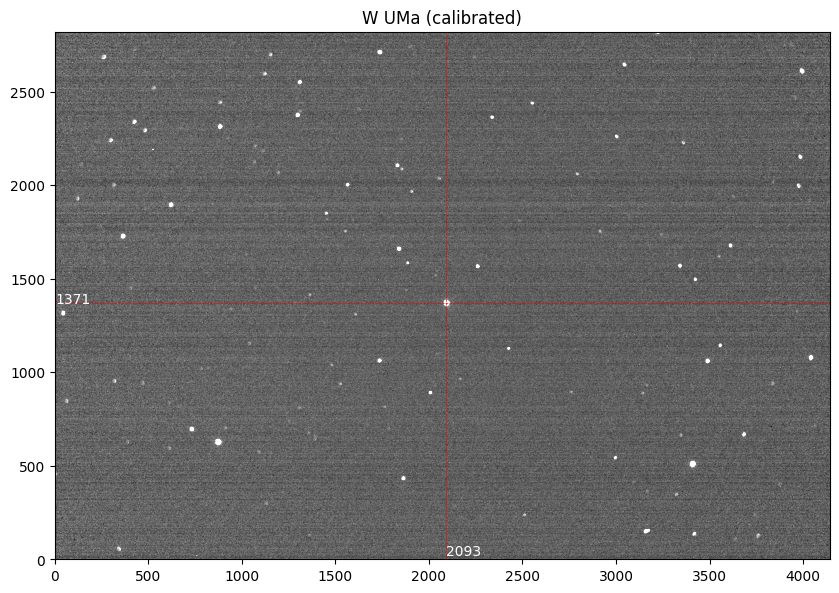

W UMa (org) ra:09:43:45.47, dec:55:57:09.11
W UMa (cal) ra:09:43:45.99, dec:55:57:11.23
W UMa (dif) ra:00:00:00.52, dec:00:00:02.12


In [5]:
x_astap_cal = 2093
y_astap_cal = 1371

# Step 1 - identify pixel location of U WMa
highlight_star(cal_fit, "W UMa (calibrated)", x_astap_cal, y_astap_cal)

# Step 2 - identify ra/dec at pixel location using WCS Fits Header
ra_cal, dec_cal = get_radec_at_pixel(cal_fit, x_astap_cal, y_astap_cal)

# Step 3 - compare these values to see how close they are.
ra_dif = abs(ra - ra_cal)
dec_dif = abs(dec - dec_cal)

print(f"W UMa (org) ra:{ra.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)}, dec:{dec.to_string(unit=u.degree, sep=':', pad=True, precision=2)}")
print(f"W UMa (cal) ra:{ra_cal.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)}, dec:{dec_cal.to_string(unit=u.degree, sep=':', pad=True, precision=2)}")
print(f"W UMa (dif) ra:{ra_dif.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)}, dec:{dec_dif.to_string(unit=u.degree, sep=':', pad=True, precision=2)}")


## Compare ASTAP (TG) for accuracy

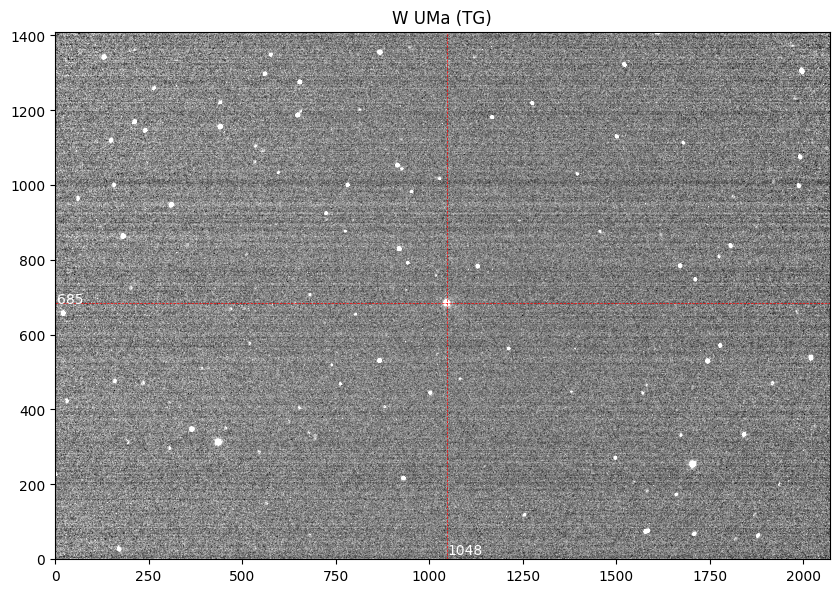

W UMa (org) ra:09:43:45.47, dec:55:57:09.11
W UMa (tg ) ra:09:43:46.02, dec:55:57:08.26
W UMa (dif) ra:00:00:00.55, dec:00:00:00.85


In [6]:
x_astap_tg = 1048
y_astap_tg = 685

# Step 1 - identify pixel location of U WMa
highlight_star(tg_fit, "W UMa (TG)", x_astap_tg, y_astap_tg)

# Step 2 - identify ra/dec at pixel location using WCS Fits Header
ra_tg, dec_tg = get_radec_at_pixel(tg_fit, x_astap_tg, y_astap_tg)

# Step 3 - compare these values to see how close they are.
ra_tg_dif = abs(ra - ra_tg)
dec_tg_dif = abs(dec - dec_tg)

print(f"W UMa (org) ra:{ra.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)}, dec:{dec.to_string(unit=u.degree, sep=':', pad=True, precision=2)}")
print(f"W UMa (tg ) ra:{ra_tg.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)}, dec:{dec_tg.to_string(unit=u.degree, sep=':', pad=True, precision=2)}")
print(f"W UMa (dif) ra:{ra_tg_dif.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)}, dec:{dec_tg_dif.to_string(unit=u.degree, sep=':', pad=True, precision=2)}")


# Additional Test

## Siril

* Calibrated FIT
* Coordinates of W UMa: (2094, 1454)

![SIRIL_CAL.png](SIRIL_CAL.png)
    


## Siril

* Tricolor Green Extracted FIT
* Coordinates of W UMa (1049, 725)

![SIRIL_TG.png](SIRIL_TG.png)